# 01b_DE_sg

In this notebook, we continue with differential expression of sarcopenia vs normal tissue for the Singapore-only cohort. 

Some questions: 
- Do we see a separation of control vs sarcopenia in the PCA/hierarchical clustering? 

- Does the number of significantly changing genes change? 

- Is Deaf1 significantly differentially expressed? 

- check against nampt because this is the gene that is shown as differentially expressed in the paper

# Setup

In [1]:
suppressPackageStartupMessages({
  library(DESeq2)
    library(knitr)
    library(GenomicFeatures)
    library(RColorBrewer)
    library(gplots)
    library(biomaRt)
    library(grid)
    library(gridExtra)
    library(ggplot2)
    library(lattice)
    library(reshape)
    library(geneplotter)
    library(limma)
    library(tidyverse)  
    
})

In [2]:
## This function is to write out the files of differentially expressed genes
## It takes in a DESeqResults object, and two strings -- the numerator and denominator used in the analysis -- and writes out csv files

write_files <- function(results, numerator, denominator){
    # these are all the genes that are differentially expressed between the two conditions, not just the significant ones
    write.csv(results, paste0(output_dir,numerator,"_",denominator,"_all.csv"), row.names = TRUE, col.names = TRUE)

    # these are the genes that are significantly differentially expressed by FDR 10% and abs(log2fc) > log2(1.5)
    sig_padj_genes <- results[!is.na(results$padj),]
    sig_padj_genes <- sig_padj_genes[sig_padj_genes$padj < 0.1,]
    sig_padj_fc_genes <- sig_padj_genes[abs(sig_padj_genes$log2FoldChange) > lfc.threshold,]
    write.csv(sig_padj_fc_genes, paste0(output_dir,numerator,"_",denominator,"_significant.csv"), row.names = TRUE, col.names = TRUE)  
}

## This function plots the volcano plot
## It takes in a data frame and two strings which are used for the title of the plot
generate_volcano <- function(data_frame, numerator, denominator){
lfc.threshold = log2(1.5)
tmp = as.data.frame(data_frame)
tmp$signif = ifelse(tmp$log2FoldChange > lfc.threshold & tmp$padj< 0.01, "U1", 
                                    ifelse(tmp$log2FoldChange > lfc.threshold & tmp$padj< 0.05, "U2",
                                      ifelse(tmp$log2FoldChange > lfc.threshold & tmp$padj< 0.1, "U3",
                                        ifelse(tmp$log2FoldChange < -1*lfc.threshold & tmp$padj< 0.01, "D1", 
                                         ifelse(tmp$log2FoldChange < -1*lfc.threshold & tmp$padj< 0.05, "D2",
                                          ifelse(tmp$log2FoldChange < -1*lfc.threshold & tmp$padj< 0.1, "D3",                                                  "N"))))))
tmp$signif = factor(tmp$signif, c("N", "U1", "U2", "U3", "D3", "D2", "D1"))
    
x = ggplot(data=tmp, aes(x=log2FoldChange, y=-log10(padj), colour= signif)) + geom_point(alpha=1.0, size=2.00) +
      ggtitle(paste("Volcano Plot:", numerator, "vs.", denominator)) + 
      scale_x_continuous("log2(fold change)", limits=c(-6, 6)) +    
      scale_y_continuous("-log10(FDR)") + 
      geom_vline(xintercept = lfc.threshold, linetype="dotdash") +
      geom_vline(xintercept = -1*(lfc.threshold), linetype="dotdash") +
      geom_hline(yintercept = -log10(0.1), colour="gray40", linetype="dotdash") +   
      geom_hline(yintercept = -log10(0.05), colour="gray40", linetype="dotdash") + 
      geom_hline(yintercept = -log10(0.01), colour="gray40", linetype="dotdash") + 
      scale_colour_manual("", values=c("#666666", "#d73027", "#f46d43", "#fdae61", "#abd9e9", "#74add1", "#4575b4" ), labels = c("N", "U1", "U2", "U3", "D3", "D2", "D1")) + theme_classic() + theme(legend.position = "none", plot.title = element_text(size = 20), axis.title=element_text(size=16,face="bold"))
print(x)
}

## This function generates the MA plots with significant changes above the threshold coloured in red and significant changes below the threshold coloured in blue
## It takes in a DESeqResults object, uses the plotMA function from DESeq2 to obtain the necessary data frame to plot

generate_ma <- function(results, numerator, denominator){
  df <- DESeq2::plotMA(results, ylim = c(-10,10), colSig = "red", returnData = TRUE)
  plot <- df %>%
  mutate(signif = ifelse(lfc > lfc.threshold & isDE == TRUE, "U", 
                         ifelse(lfc < -lfc.threshold & isDE == TRUE, "D", "N"))) %>%
  ggplot(aes(x=mean, y=lfc, colour = signif)) + 
  geom_point(size = 1.5, alpha = 0.8) + 
  theme_classic() + 
  geom_hline(yintercept=0, colour="grey40", lwd = 1) + 
  #stat_smooth(se = FALSE, method = "loess", color = "red3") + 
  theme_classic() + 
  scale_colour_manual(values=c("#4575b4","#a3a3a3","#d73027"), labels = c("D", "N", "U")) +
  ylim(c(-10,10)) +
  theme(legend.position = "none") +
  labs(title = paste("Volcano Plot:", numerator, "vs.", denominator)) +
  ylab("Log fold change") +
  xlab("Mean of normalized counts") +
  scale_x_log10()
  return(plot)
}



## Load data

In [3]:
dds = readRDS("../output/01a_QC_sg/dds_quality_control.RDS")
dds_corrected = readRDS("../output/01a_QC_sg/dds_corrected.RDS")
ensembl.genes= readRDS("../../data/ensembl.genes.RDS")
lfc.threshold = log2(1.5)

## Creating the output dir
if(!dir.exists("../output/01b_DE_sg")){
  dir.create("../output/01b_DE_sg")
}

output_dir <- "../output/01b_DE_sg/"

In [4]:
filter = apply(counts(dds, normalized=TRUE), 1, function(x){ mean(x) >= 10 })
dds = dds[filter, ]

In [5]:
filter_2 = apply(counts(dds_corrected, normalized=TRUE), 1, function(x){ mean(x) >= 10 })
dds_corrected = dds_corrected[filter_2, ]

# Non-corrected

## RLD plot

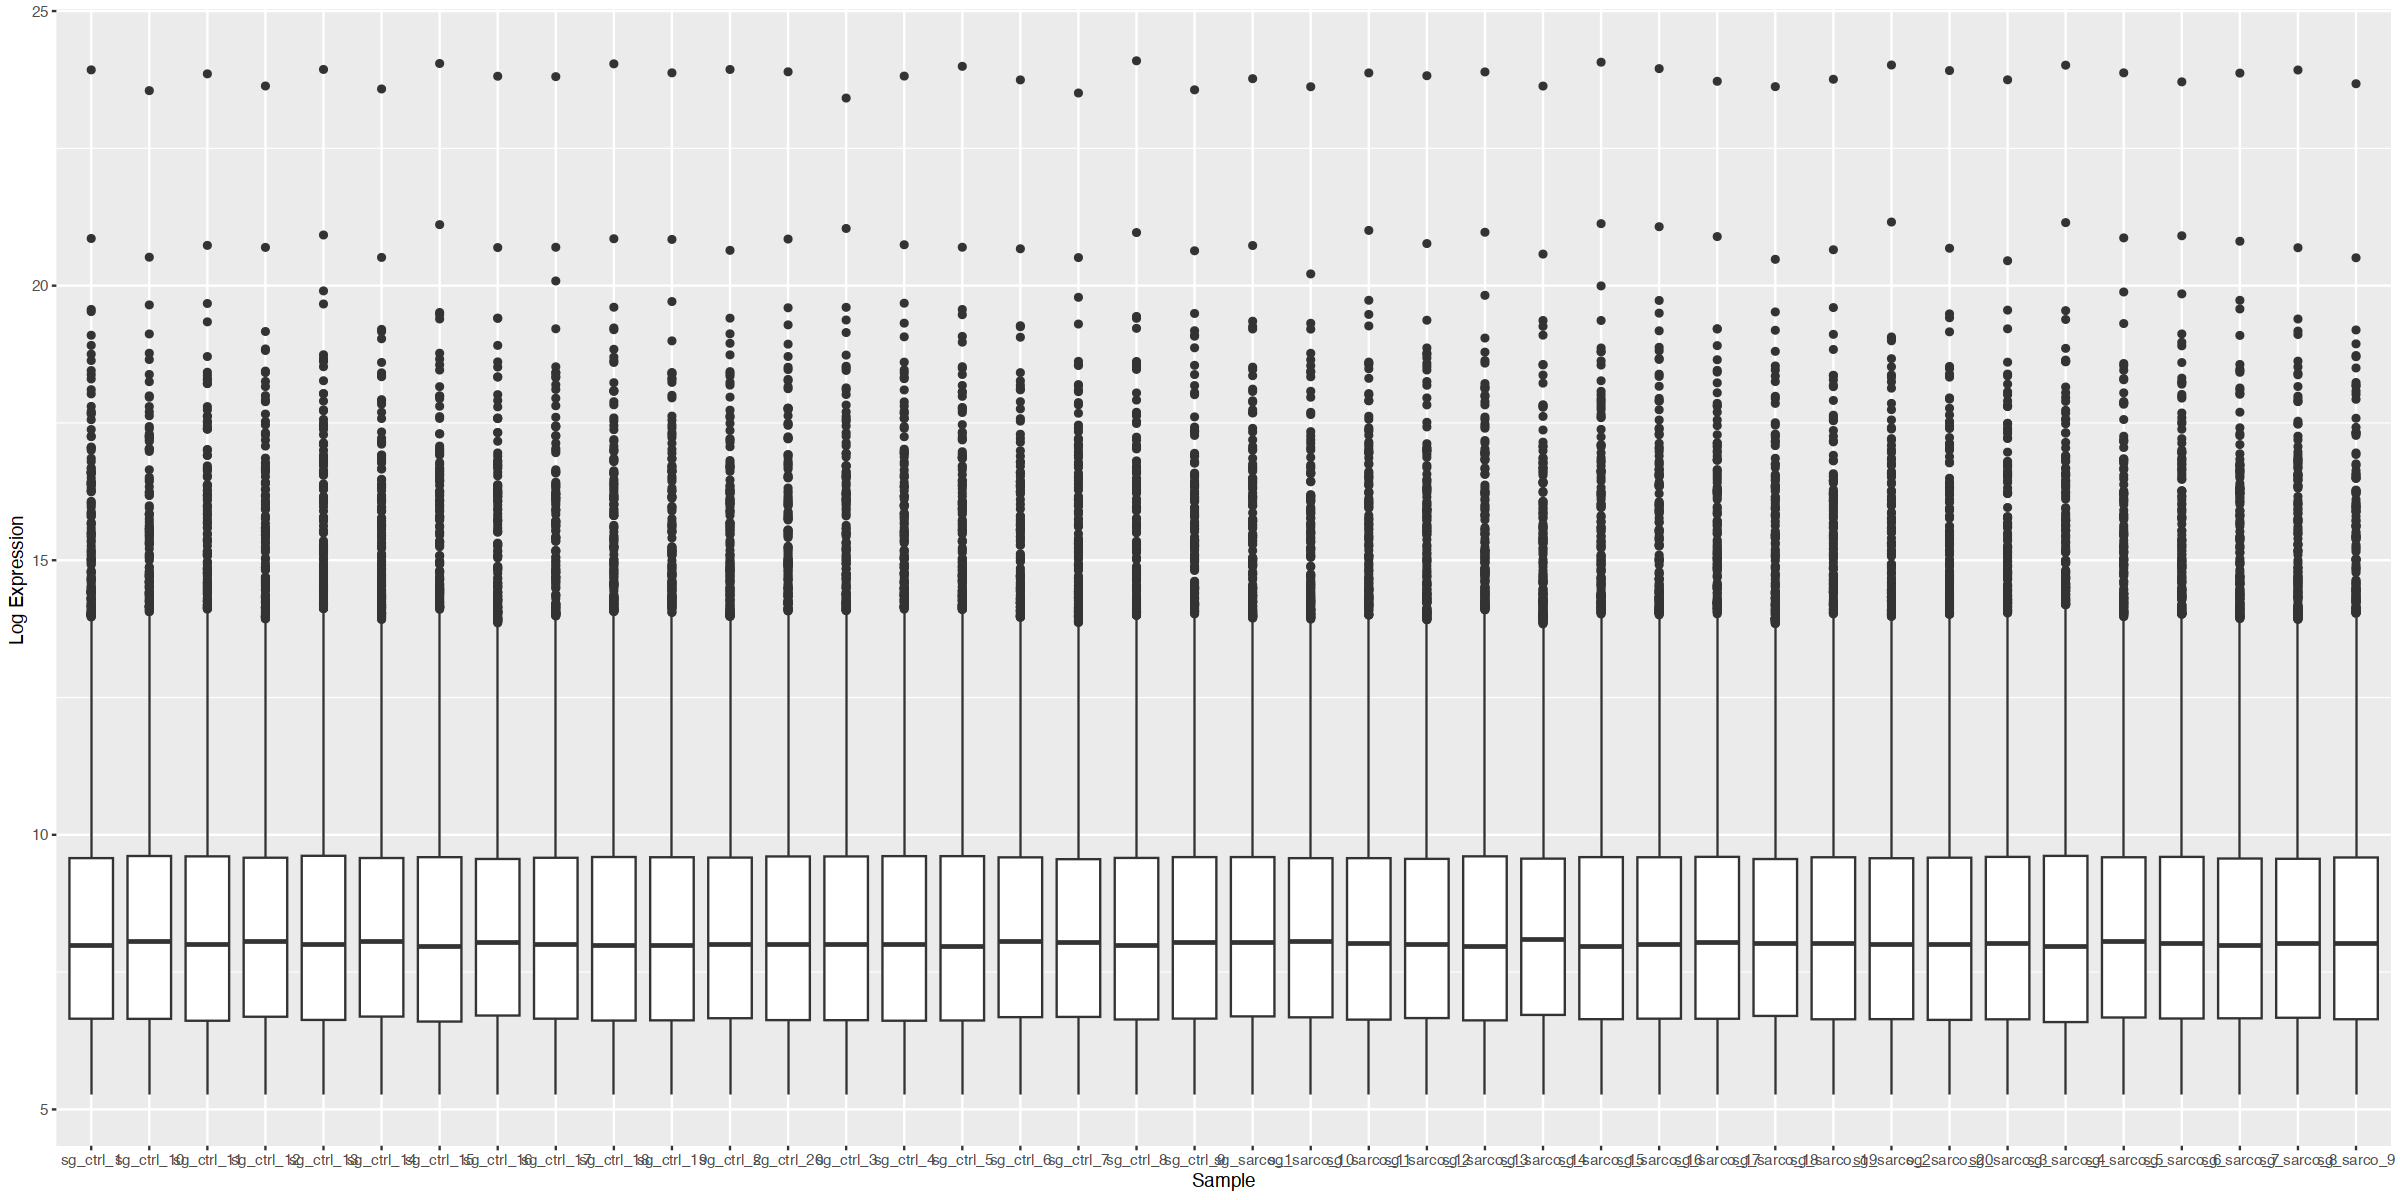

In [6]:
rld <- vst(dds)

options(repr.plot.height = 10, repr.plot.width = 20)
assay(rld) %>%
  as.data.frame() %>%
  gather() %>%
  ggplot(aes(x=key, y=value)) + 
  geom_boxplot() + ylab("Log Expression ") + xlab("Sample")

## Wald test

In [7]:
dds = nbinomWaldTest(dds)

In [8]:
results = results(dds, 
                  contrast = c("condition", "sarco", "ctrl"),  
                  filter=rowMeans(counts(dds, normalized=TRUE)), 
                  test="Wald", alpha=0.1, independentFiltering=TRUE)

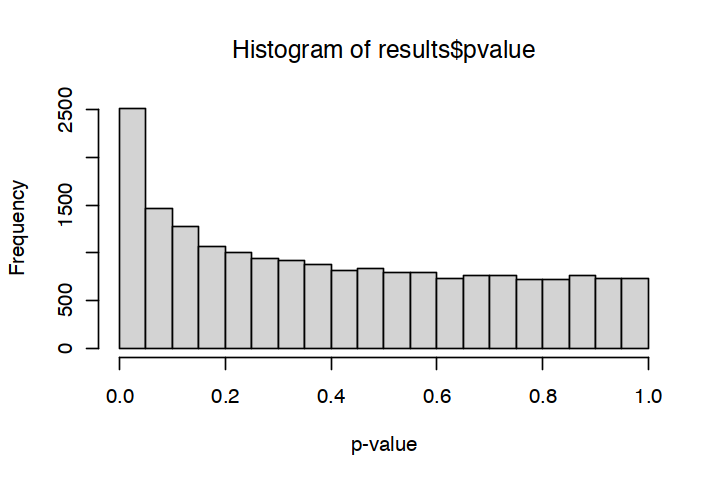

In [9]:
options(repr.plot.height = 4, repr.plot.width = 6)
results$gene_biotype= ensembl.genes$gene_biotype[match(row.names(results), ensembl.genes$gene_id)]
results$external_gene_name= ensembl.genes$external_gene_name[match(row.names(results), ensembl.genes$gene_id)]

hist(results$pvalue, xlab = "p-value", ylab = "Frequency")

## Number of significant genes

In [10]:
sum(results$padj < 0.1 & abs(results$log2FoldChange) > lfc.threshold, na.rm = T)

[1] 6

In [11]:
write_files(results, "sarco", "ctrl")

Warning message in write.csv(results, paste0(output_dir, numerator, "_", denominator, :
“attempt to set 'col.names' ignored”
Warning message in write.csv(sig_padj_fc_genes, paste0(output_dir, numerator, "_", :
“attempt to set 'col.names' ignored”


Warning message:
“Removed 9393 rows containing missing values (`geom_point()`).”


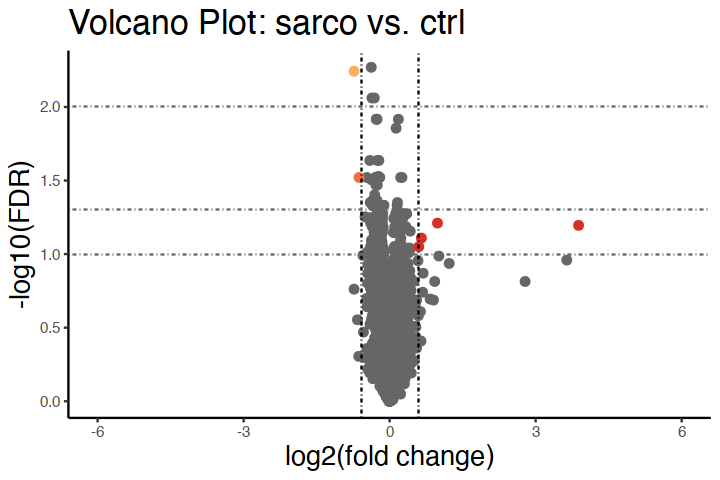

In [12]:
options(repr.plot.height = 4, repr.plot.width = 6)

generate_volcano(results,"sarco","ctrl")

In [13]:
summary(results$log2FoldChange)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-3.238119 -0.073385  0.002488  0.014813  0.083967  4.190781 

## Replicating the pvalue plot in the figure

I strongly suspect that the pvalue plot in Supplementary Figure 1 has not been corrected for multiple testing. Let's confirm our suspicions: 

In [14]:
res_plot <- as.data.frame(results)

Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


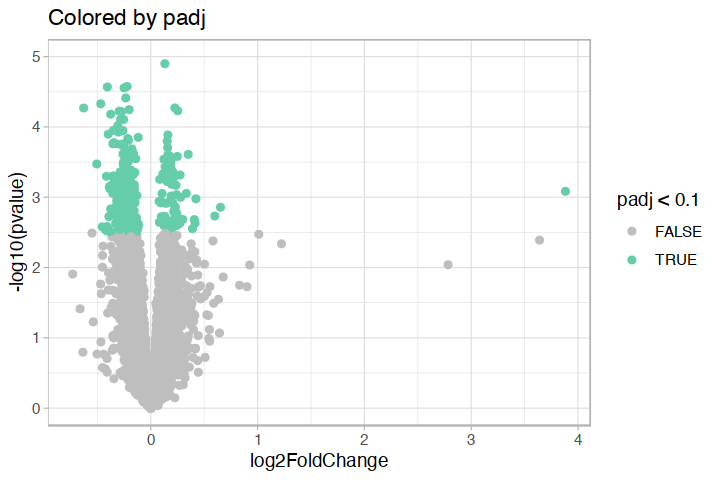

In [15]:
ggplot(na.omit(res_plot), 
      aes(x = log2FoldChange, y = -log10(pvalue), 
          color = padj < 0.1
      )
       )+
    scale_y_continuous(limits = c(0, 5)) +
    geom_point() +
    labs(title = "Colored by padj") +
    scale_color_manual(values = c("grey", "aquamarine3")) +
    theme_light()

Nope, that's not it. 

Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


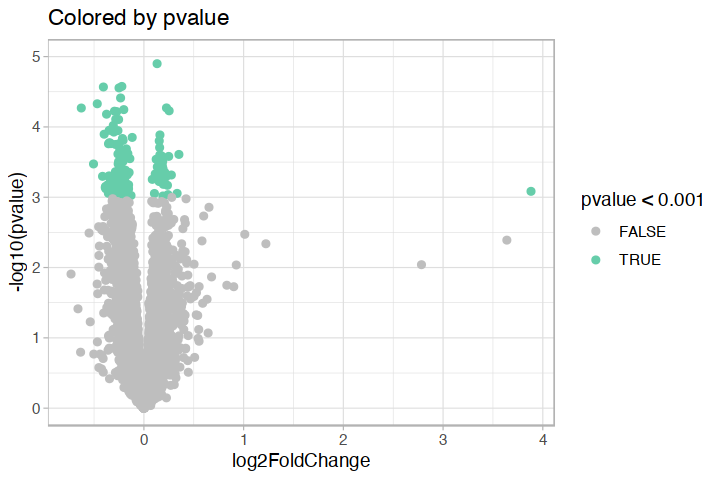

In [16]:
ggplot(na.omit(res_plot), 
      aes(x = log2FoldChange, y = -log10(pvalue), 
          color = pvalue < 0.001
      )
       )+
    scale_y_continuous(limits = c(0, 5)) +
    geom_point() +
    labs(title = "Colored by pvalue") +
    scale_color_manual(values = c("grey", "aquamarine3")) +
    theme_light()

Yup, that's it. 

## Deaf1

In [17]:
deaf1 <- "ENSG00000177030"

results[rownames(results) == deaf1, ]

log2 fold change (MLE): condition sarco vs ctrl 
Wald test p-value: condition sarco vs ctrl 
DataFrame with 1 row and 8 columns
                 baseMean log2FoldChange     lfcSE      stat    pvalue
                <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000177030   329.485       0.060022 0.0529592   1.13336  0.257061
                     padj   gene_biotype external_gene_name
                <numeric>    <character>        <character>
ENSG00000177030  0.596697 protein_coding              DEAF1

In [18]:
nampt <- "ENSG00000105835"

results[rownames(results) == nampt, ]

log2 fold change (MLE): condition sarco vs ctrl 
Wald test p-value: condition sarco vs ctrl 
DataFrame with 1 row and 8 columns
                 baseMean log2FoldChange     lfcSE      stat     pvalue
                <numeric>      <numeric> <numeric> <numeric>  <numeric>
ENSG00000105835    1623.9      -0.243547 0.0887752  -2.74341 0.00608046
                     padj   gene_biotype external_gene_name
                <numeric>    <character>        <character>
ENSG00000105835  0.130239 protein_coding              NAMPT

# Batch-corrected

## Rld plot

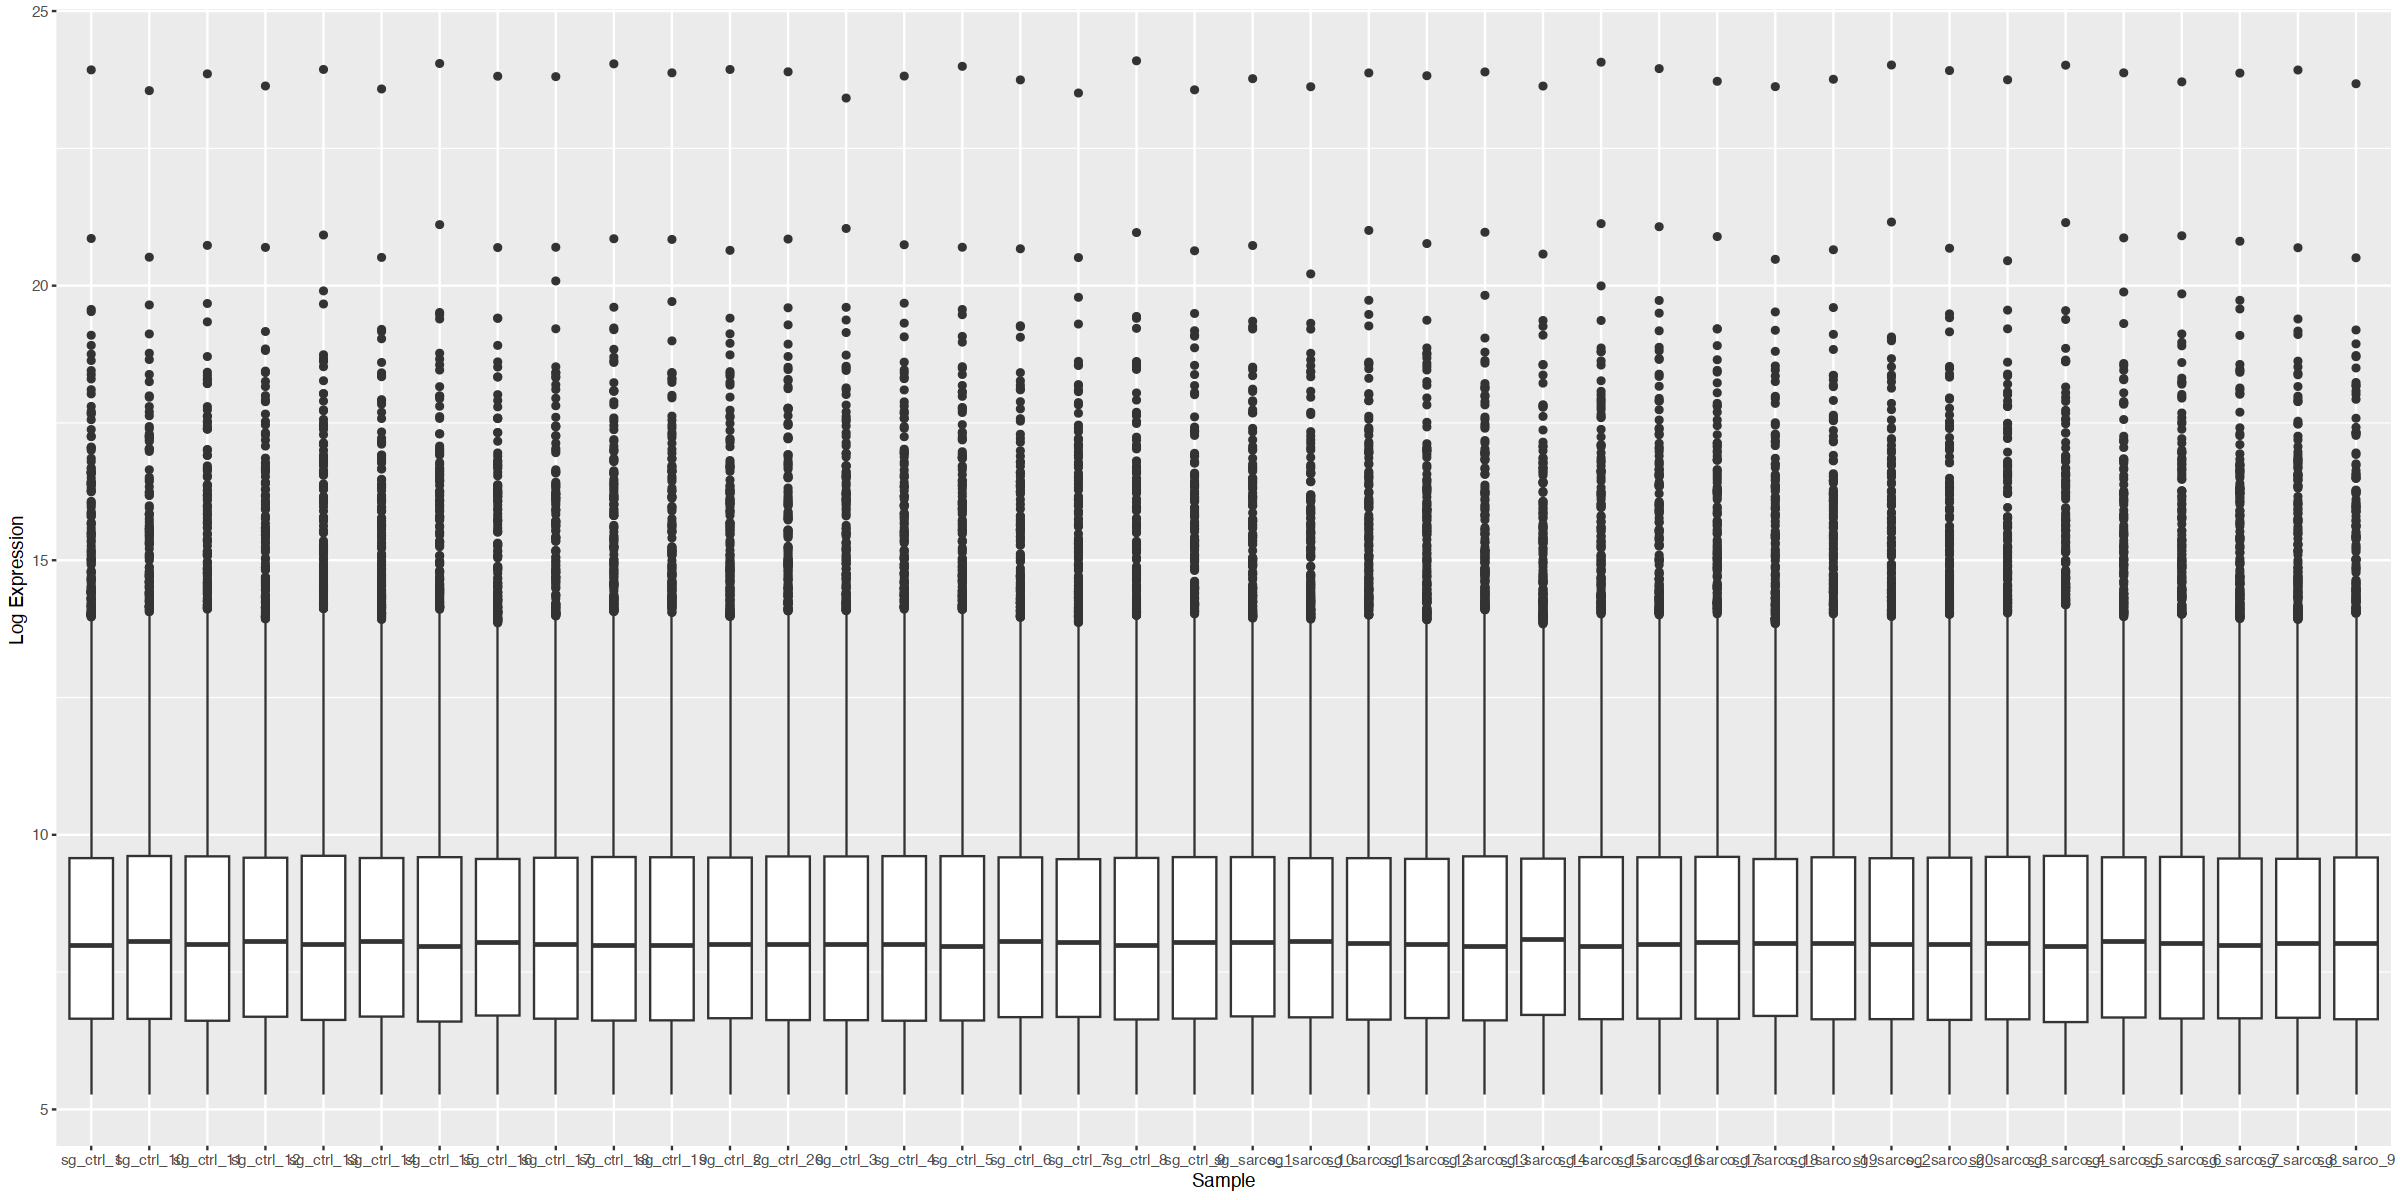

In [19]:
rld_corrected <- vst(dds_corrected)

options(repr.plot.height = 10, repr.plot.width = 20)
assay(rld_corrected) %>%
  as.data.frame() %>%
  gather() %>%
  ggplot(aes(x=key, y=value)) + 
  geom_boxplot() + ylab("Log Expression ") + xlab("Sample")

## Wald test

In [20]:
dds_corrected = nbinomWaldTest(dds_corrected)

results_corrected = results(dds_corrected, 
                  contrast = c("condition", "sarco", "ctrl"),  
                  filter=rowMeans(counts(dds, normalized=TRUE)), 
                  test="Wald", alpha=0.1, independentFiltering=TRUE)

found results columns, replacing these



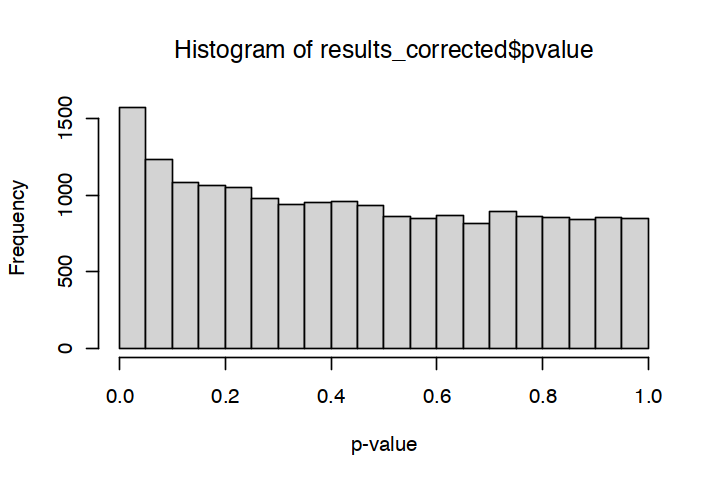

In [21]:
options(repr.plot.height = 4, repr.plot.width = 6)
results_corrected$gene_biotype= ensembl.genes$gene_biotype[match(row.names(results_corrected), ensembl.genes$gene_id)]
results_corrected$external_gene_name= ensembl.genes$external_gene_name[match(row.names(results_corrected), ensembl.genes$gene_id)]

hist(results_corrected$pvalue, xlab = "p-value", ylab = "Frequency")

## Number of significant genes

In [22]:
sum(results_corrected$padj < 0.1 & abs(results_corrected$log2FoldChange) > lfc.threshold, na.rm = T)

[1] 1

In [23]:
write_files(results_corrected, "sarco_corrected", "ctrl_corrected")

Warning message in write.csv(results, paste0(output_dir, numerator, "_", denominator, :
“attempt to set 'col.names' ignored”
Warning message in write.csv(sig_padj_fc_genes, paste0(output_dir, numerator, "_", :
“attempt to set 'col.names' ignored”


Warning message:
“Removed 47 rows containing missing values (`geom_point()`).”


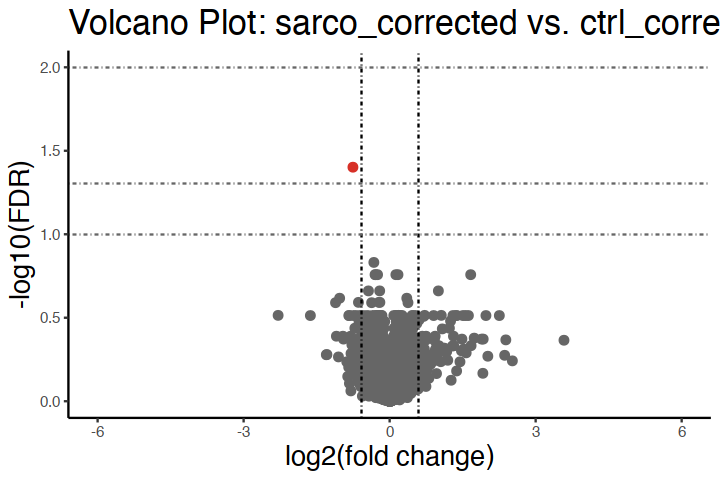

In [24]:
options(repr.plot.height = 4, repr.plot.width = 6)

generate_volcano(results_corrected,"sarco_corrected","ctrl_corrected")

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


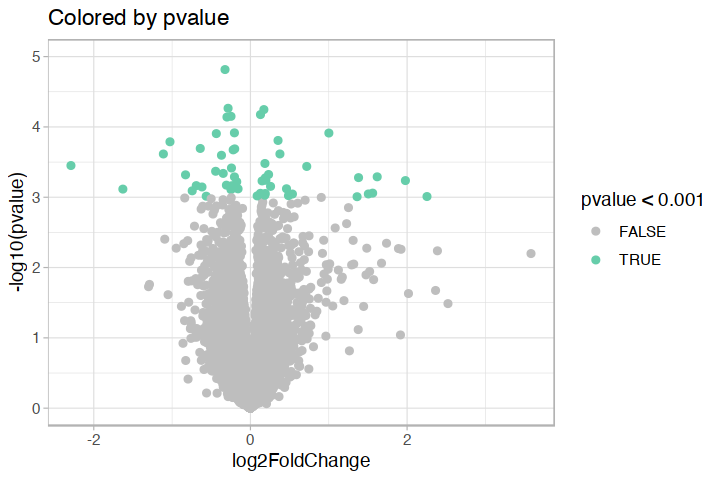

In [25]:
ggplot(na.omit(as.data.frame(results_corrected)), 
      aes(x = log2FoldChange, y = -log10(pvalue), 
          color = pvalue < 0.001
      )
       )+
    scale_y_continuous(limits = c(0, 5)) +
    geom_point() +
    labs(title = "Colored by pvalue") +
    scale_color_manual(values = c("grey", "aquamarine3")) +
    theme_light()

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


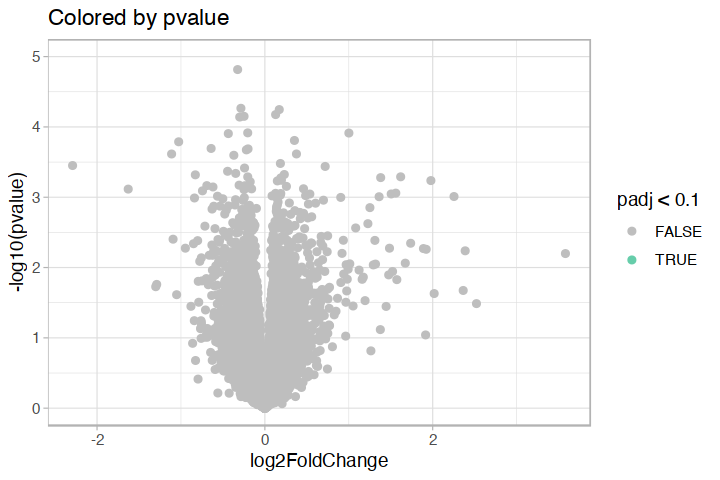

In [26]:
ggplot(na.omit(as.data.frame(results_corrected)), 
      aes(x = log2FoldChange, y = -log10(pvalue), 
          color = padj < 0.1
      )
       )+
    scale_y_continuous(limits = c(0, 5)) +
    geom_point() +
    labs(title = "Colored by pvalue") +
    scale_color_manual(values = c("grey", "aquamarine3")) +
    theme_light()

pdf 
  2

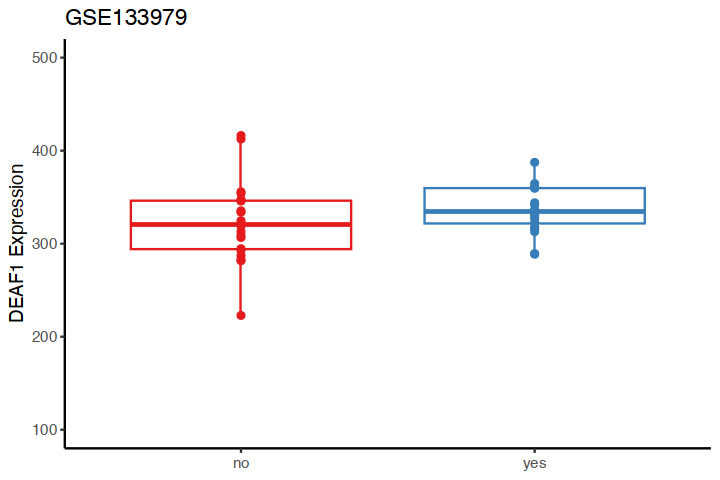

In [40]:
th <- theme_classic() +
  theme(axis.title.y = element_text(face = "italic"),
        legend.position = "none")
gse_lab <- "GSE133979"


df_sarc = data.frame(norm_counts = counts(dds, normalized=TRUE)["ENSG00000177030",],
                    condition = colData(dds)$sarcopenia_status)

p1 <- ggplot(df_sarc, aes(x = condition, y = norm_counts,
                          color = condition)) +
  geom_boxplot() +
  geom_point() +
  scale_y_continuous(limits = c(100, 500)) +
  labs(
    title = gse_lab,
    y = "DEAF1 Expression") +
  scale_color_brewer(palette = "Set1") +
  th +
  theme(axis.title.x = element_blank())


p1

pdf("SG_DEAF1.pdf")
p1
dev.off()

## Deaf1

In [27]:
deaf1 <- "ENSG00000177030"

results_corrected[rownames(results_corrected) == deaf1, ]

log2 fold change (MLE): condition sarco vs ctrl 
Wald test p-value: condition sarco vs ctrl 
DataFrame with 1 row and 8 columns
                 baseMean log2FoldChange     lfcSE      stat    pvalue
                <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000177030   329.485       0.039675 0.0554479  0.715538  0.474277
                     padj   gene_biotype external_gene_name
                <numeric>    <character>        <character>
ENSG00000177030   0.88831 protein_coding              DEAF1

## Nampt

In [28]:
results_corrected[rownames(results_corrected) == nampt, ]

log2 fold change (MLE): condition sarco vs ctrl 
Wald test p-value: condition sarco vs ctrl 
DataFrame with 1 row and 8 columns
                 baseMean log2FoldChange     lfcSE      stat    pvalue
                <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000105835    1623.9      -0.214041  0.093115  -2.29868 0.0215233
                     padj   gene_biotype external_gene_name
                <numeric>    <character>        <character>
ENSG00000105835  0.530757 protein_coding              NAMPT

# Session Info

In [29]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Monterey 12.6.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] lubridate_1.9.2             forcats_1.0.0              
 [3] stringr_1.5.0               dplyr_1.1.2                
 [5] purrr_1.0.1                 readr_2.1.4                
 [7] tidyr_1.3.0                 tibble_3.2.1               
 [9] tidyverse_2.0.0             limma_3.54.2               
[11] geneplotter_1.76.0          annotate_1.76.0            
[13] XML_3.99-0.14               reshape_0.8.9              
[15] lattice_0.21-8              ggplot2_3.4.2              
[17] gridExtra_2.3  